# Анализ прибольности тарифов "Смарт" и "Ультра" оператора сотовой связи "Мегалайн"

### Есть данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько 
### звонков и сообщений каждый отправил за 2018 год. 
### Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов

### Тариф «Смарт»

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения
минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в
тарифе засчитывается целая минута);
2. сообщение: 3 рубля;
3. 1 Гб интернет-трафика: 200 рублей.

### Тариф «Ультра»

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
1. минута разговора: 1 рубль;
2. сообщение: 1 рубль;
3. 1 Гб интернет-трафика: 150 рублей.

# Шаг 1. Изучаем исходдные данные.

In [171]:
import pandas as pd # ипортируем все необходимы для проета библиотеки
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Информация о дате и продолжительности звонков.

In [172]:
calls = pd.read_csv('/datasets/calls.csv',parse_dates=[1,]) # загружаем датасет звонков в переменную calls

In [173]:
calls.head() # отображение первых пяти строчек датасета.

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Датасет содержит id звонка, дату звонка (call_date), продолжительность звонка в минутах (duration) и id пользователся (user_id).

### Иформация о дате и расходе интернет трафика посессионо.

In [174]:
internet = pd.read_csv('/datasets/internet.csv',parse_dates=[2,]) # загружаем датасет интернет трафика в переменную internet

In [175]:
internet.head() # отображение первых пяти строчек датасета

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Датасет отражает информацию о id интернет сессии, потраченных мегабайтах за сессию (mb_used), дату интернет сессии (session_data) и id пользователя.

### Информация о sms сообщениях.

In [176]:
messages = pd.read_csv('/datasets/messages.csv',parse_dates=[1,]) # загружаем датасет сообщений в переменную messages

In [177]:
messages.head() # отображение первых пяти строк датасета

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Датасет отражает id сообщения, его дату(message_date) и id пользовтаеля (user_ud).

### Информация о тарифных планах.

In [178]:
tariffs = pd.read_csv('/datasets/tariffs.csv',parse_dates=[1,]) # загружаем датасет тарифов в файл tariffs
tariffs 

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Небольшой датасет отражающий количество sms, мегабайтов и минут включенных в каждый тариф, стоимость тарифа и стоимость услуг вне свыше включенных количеств услуг.

### Клиентская база.

In [179]:
users = pd.read_csv('/datasets/users.csv',parse_dates=[2,-2]) # загружаем ds пользоватлей в файл users

In [180]:
users.head() # отображаем первые пять строк дата сэта списка пользователей

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Дата сэт отражающий id пользователя (user_id), его возраст (age), город проживания (city), фамилию и имя (first_name, last_name), дату регистрации и выхода (reg_date, chutn_date), название используемого тарифа (tariff).

# Шаг 2. Подготовка данных.

## Приведение данных к нужным типам и исправление ошибок.

In [181]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [182]:
calls.nunique()

id           202607
call_date       365
duration       2871
user_id         492
dtype: int64

In [183]:
calls.describe(percentiles=[0.02,0.2,0.9,0.99]) # посмотрим на звонки дополнительно по процентелям 2% 20% 90% и 99%

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
2%,0.000000,1011.000000
20%,0.120000,1100.000000
50%,6.000000,1260.000000
90%,14.940000,1454.000000
99%,22.240000,1494.000000
max,38.000000,1499.000000


2% датасета нули. Имеются сверхкоротные звонки. Предположительно это могу быть недозвоны. Необходимо связаться с поставщиком данных для уточнения.

In [184]:
calls['duration']= calls['duration'].apply(np.ceil) # округляем значения звонков в большую сторону

In [185]:
internet['mb_used']= internet['mb_used'].apply(np.ceil) # округлаем значения израсходованного интернет трафика в большую сторону

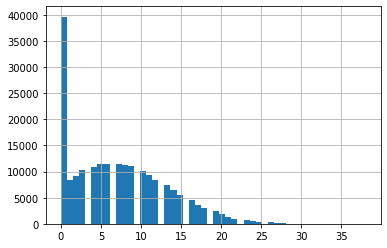

In [186]:
calls['duration'].hist(bins=50) # взглянем на визуализацию данных продолжительности звонков

В данных по звонкам есть пропуски. Это проблема. Необходимо связаться с постовщиком данных.

In [187]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


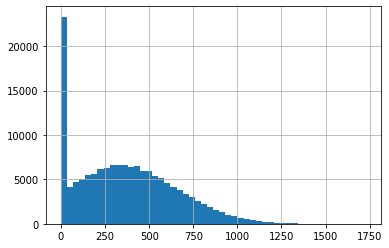

In [188]:
internet['mb_used'].hist(bins = 50) # визуализация использования интернет трафика

In [189]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


## Исправление ошибок

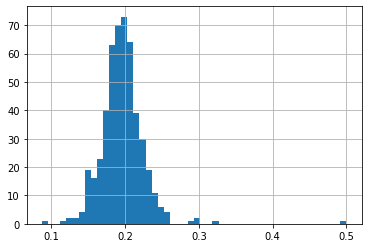

In [190]:
calls.groupby('user_id')['duration'].agg(lambda x: sum(x == 0)/len(x)).hist(bins = 50) 
# взглянем на вызуализацию нулевых значений в звонках

Нулевые значения в звонках имеют нормальное распределение. Наличие нулей скорее всего это ошибки в данных. 

In [191]:
temp = calls.groupby('user_id')['duration'].median() # среднее значение звонков каждого пользователя

In [192]:
temp

user_id
1000    6.0
1001    6.0
1002    6.0
1003    6.0
1004    4.0
       ... 
1495    6.0
1496    6.0
1497    7.0
1498    7.0
1499    7.0
Name: duration, Length: 492, dtype: float64

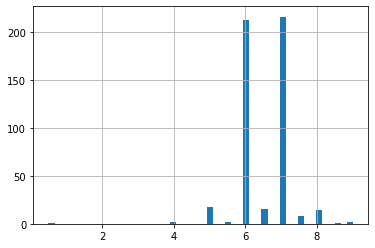

In [193]:
temp.hist(bins = 50) # взглянем на медианы звонков

In [194]:
users['month'] = users['reg_date'].map(lambda x: x.strftime('%Y-%m-01')) 
# преобразуем даты регистрации пользователй в месяцы с перым числом

In [195]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
month         500 non-null object
dtypes: datetime64[ns](2), int64(2), object(5)
memory usage: 35.3+ KB


In [196]:
calls['month'] = pd.to_datetime(calls['call_date'].map(lambda x: x.strftime('%Y-%m-01')))
# преобразуем даты телефонных звонков в формат месяца и первого исла с годом

In [197]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,113.0,2018-11-25,1000
1,1000_1,1053.0,2018-09-07,1000
2,1000_2,1198.0,2018-06-25,1000
3,1000_3,551.0,2018-08-22,1000
4,1000_4,303.0,2018-09-24,1000


In [198]:
internet['month'] = pd.to_datetime(internet['session_date'].map(lambda x: x.strftime('%Y-%m-01')))
# преобразуем даты интернет селлий в формат год меяц первое число

In [199]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [200]:
messages['month'] = pd.to_datetime(messages['message_date'].map(lambda x: x.strftime('%Y-%m-01')))
# преобразуем дату сообщений в формат год месяц первое число

In [201]:
tariffs

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [202]:
tariffs.set_index('tariff_name',inplace = True) # устанавливаем индексы в тарифах

## Группировка данных

In [203]:
gr_mes = messages.groupby(['user_id','month'])['id'].count() 
# посчитаем количество сообщений каждого пользователя за каждый месяц 

In [204]:
gr_mes

user_id  month     
1000     2018-05-01    22
         2018-06-01    60
         2018-07-01    75
         2018-08-01    81
         2018-09-01    57
                       ..
1498     2018-10-01    42
1499     2018-09-01    11
         2018-10-01    48
         2018-11-01    59
         2018-12-01    66
Name: id, Length: 2717, dtype: int64

## Подсчет значений

In [205]:
buf = []
for i in [internet,messages,calls]:
    buf.append(i.groupby(['user_id','month'])['id'].count())
# цикл формирующий таблицу значений количества интернет трафика, 
# сообщений и продолжительности звонков по месяцам для каждого пользователя

In [206]:
buf

[user_id  month     
 1000     2018-05-01     5
          2018-06-01    49
          2018-07-01    29
          2018-08-01    29
          2018-09-01    27
                        ..
 1498     2018-10-01    59
 1499     2018-09-01     5
          2018-10-01    58
          2018-11-01    49
          2018-12-01    45
 Name: id, Length: 3203, dtype: int64, user_id  month     
 1000     2018-05-01    22
          2018-06-01    60
          2018-07-01    75
          2018-08-01    81
          2018-09-01    57
                        ..
 1498     2018-10-01    42
 1499     2018-09-01    11
          2018-10-01    48
          2018-11-01    59
          2018-12-01    66
 Name: id, Length: 2717, dtype: int64, user_id  month     
 1000     2018-05-01    22
          2018-06-01    43
          2018-07-01    47
          2018-08-01    52
          2018-09-01    58
                        ..
 1498     2018-10-01    41
 1499     2018-09-01     9
          2018-10-01    68
          2018-11-01    

In [207]:
pd.concat(buf, axis = 1) # объеденяем в общую таблицу полученные значения в buf по оси. 
#Идентификаторы с лева на право интернет трафик, сообщения и звонки соответственно

id    id    id
user_id month                       
1000    2018-05-01   5.0  22.0  22.0
        2018-06-01  49.0  60.0  43.0
        2018-07-01  29.0  75.0  47.0
        2018-08-01  29.0  81.0  52.0
        2018-09-01  27.0  57.0  58.0
...                  ...   ...   ...
1498    2018-10-01  59.0  42.0  41.0
1499    2018-09-01   5.0  11.0   9.0
        2018-10-01  58.0  48.0  68.0
        2018-11-01  49.0  59.0  74.0
        2018-12-01  45.0  66.0  69.0

[3214 rows x 3 columns]

In [208]:
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,2018-07-01
1,1000_1,2018-08-17,0.0,1000,2018-08-01
2,1000_2,2018-06-11,3.0,1000,2018-06-01
3,1000_3,2018-09-21,14.0,1000,2018-09-01
4,1000_4,2018-12-15,6.0,1000,2018-12-01


In [209]:
gr_mes = messages.groupby(['user_id','month'])['id'].count()
# группируем и считаем отдельно количество сообщений для каждого пользователя по месяцам

In [210]:
gr_mb = internet.groupby(['user_id','month'])['mb_used'].sum()
# группируем и считаем отдельно количество интернет трафика для каждого пользователя по месяцам

In [211]:
gr_call = calls.groupby(['user_id','month'])['duration'].sum()
# группируем и считаем отдельно количество продолжительностей звонков для каждого пользователя по месяцам

In [212]:
gr_all = pd.concat((gr_mes,gr_mb,gr_call),axis = 1)
# объеденяем все в общую таблицу 

In [213]:
gr_all.columns = ['cnt_mes','mb_used','duration'] 
# переименоываем столбцы

In [214]:
users.set_index('user_id',inplace=True)
# пеерзапускаем индексы

In [215]:
gr_all = gr_all.join(users[['tariff','city']])
# присоедением столбцы тарифов и городов

In [217]:
gr_all

cnt_mes  mb_used  duration tariff         city
user_id month                                                     
1000    2018-05-01     22.0   2256.0     159.0  ultra    Краснодар
        2018-06-01     60.0  23257.0     172.0  ultra    Краснодар
        2018-07-01     75.0  14016.0     340.0  ultra    Краснодар
        2018-08-01     81.0  14070.0     408.0  ultra    Краснодар
        2018-09-01     57.0  14581.0     466.0  ultra    Краснодар
...                     ...      ...       ...    ...          ...
1498    2018-10-01     42.0  20604.0     247.0  smart  Владикавказ
1499    2018-09-01     11.0   1848.0      70.0  smart        Пермь
        2018-10-01     48.0  17809.0     449.0  smart        Пермь
        2018-11-01     59.0  17984.0     612.0  smart        Пермь
        2018-12-01     66.0  13077.0     492.0  smart        Пермь

[3214 rows x 5 columns]

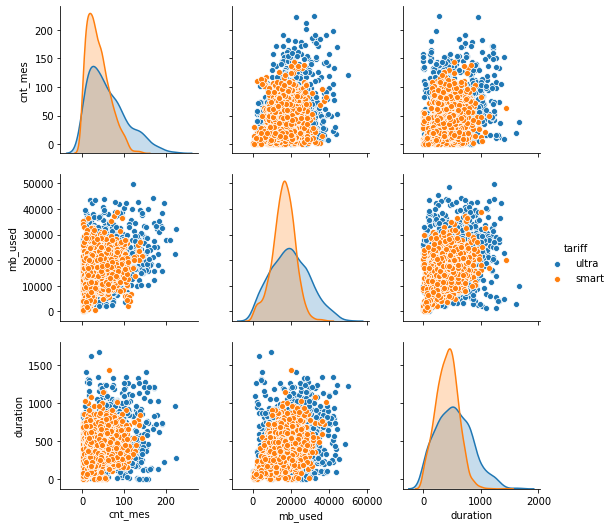

In [218]:
sns.pairplot(data = gr_all,hue = 'tariff') 
# взглянем на распределение количесва смс, интернет трафика и звонков по тарифам

## Предварительные выводы
1. Пользователи тарифа ultra более разнообразны в расходе смс, интернет трафика и звонков.
2. Пользовтали тарифа smart более экономичны и большенство держиться в среднеи значении расхода.
3. Для аудитории тарифа smart расположенной в правой части распределений можно разработать другой тариф для получения большей прибыли.
4. Все графики имеют нормальное распределение.
5. Пики средних значений у всех пользователей практически одинаковы.

In [219]:
tariffs['mg_per_month_included'] = tariffs['mg_per_month_included'].astype(int)
# преобразуем значения столбца пакетов интернет трафика в целочисленные 

In [220]:
gr_all.fillna(0,inplace=True)
# удаляем значения NaN в исходной таблице

In [221]:
gr_all.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 2018-05-01 00:00:00) to (1499, 2018-12-01 00:00:00)
Data columns (total 5 columns):
cnt_mes     3214 non-null float64
mb_used     3214 non-null float64
duration    3214 non-null float64
tariff      3214 non-null object
city        3214 non-null object
dtypes: float64(3), object(2)
memory usage: 159.1+ KB


In [222]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, smart to ultra
Data columns (total 7 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
dtypes: int64(7)
memory usage: 128.0+ bytes


## Подсчет помесячной выручки каждого пользователя

In [223]:
def calc_money(row):
    sum_rub = tariffs.loc[row['tariff'],'rub_monthly_fee']
    sum_rub += max(row['cnt_mes'] - tariffs.loc[row['tariff'],'messages_included'],0)*tariffs.loc[row['tariff'],'rub_per_message']
    sum_rub += max(row['duration'] - tariffs.loc[row['tariff'],'minutes_included'],0)*tariffs.loc[row['tariff'],'rub_per_minute']
    sum_rub += max(np.ceil((row['mb_used'] - tariffs.loc[row['tariff'],'mg_per_month_included'])//1024),0)*tariffs.loc[row['tariff'],'rub_per_gb']

    return sum_rub
# функция calc_money считаем выручку и подготовленна к рассширению на большее количество тарифов
# если количество смс, mb или минут не выходит за рамки тарифа, то прибавляется ноль 
# (максимум из отрицательного и нуля это ноль)
# если количество выходит за рамки, то прибовляется стоимость излишка
# мегабайты переведены в гигабайты

In [224]:
gr_all['money'] = gr_all.apply(calc_money,axis = 1) 

In [225]:
gr_all

cnt_mes  mb_used  duration tariff         city   money
user_id month                                                             
1000    2018-05-01     22.0   2256.0     159.0  ultra    Краснодар  1950.0
        2018-06-01     60.0  23257.0     172.0  ultra    Краснодар  1950.0
        2018-07-01     75.0  14016.0     340.0  ultra    Краснодар  1950.0
        2018-08-01     81.0  14070.0     408.0  ultra    Краснодар  1950.0
        2018-09-01     57.0  14581.0     466.0  ultra    Краснодар  1950.0
...                     ...      ...       ...    ...          ...     ...
1498    2018-10-01     42.0  20604.0     247.0  smart  Владикавказ  1550.0
1499    2018-09-01     11.0   1848.0      70.0  smart        Пермь   550.0
        2018-10-01     48.0  17809.0     449.0  smart        Пермь   950.0
        2018-11-01     59.0  17984.0     612.0  smart        Пермь  1313.0
        2018-12-01     66.0  13077.0     492.0  smart        Пермь   598.0

[3214 rows x 6 columns]

# Шаг 3. Анализ данных.

См. гистограммы и предварительные выводы в шаге 2.

# Шаг 4. Проверка гипотиз.

## Моделируем ситуации по гипотезам:
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

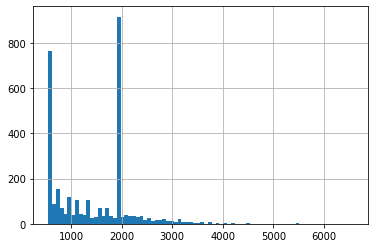

In [250]:
gr_all['money'].hist(bins=80) # распределение генеральной совокупности прибыли

Распределение в заданной подвыборке. Доход не распределен нормально. Есть возможность воспользоваться bootstrap. 

In [248]:
def bootstrap(arr,n=100,N_TRAIL = 3000,func = np.mean): 
    # где arr массив подвыборок, n - число экспериментов,
    # N_TRAIL - размер и функция среднего значения
    res = []
    n = min(len(arr),n) # есть ограничения выборка не должна быть меньше 100. Ставим это ограничение если выборка будет меньше.
    # Формируем цикл попыток
    for _ in range(N_TRAIL):
        # Создаем выборку размера n
        subsample = np.random.choice(arr, size = (n,))
        # Вычисление статистик
        stat = func(subsample)
        res.append(stat)
    return res # shape (N_TRAIL,)

Оба критерия оцениваем по персентилям. Критерий оценки гипотезы насколько пересикаются или не перисекаются границы персентелей.

## 1. Различается ли средняя выручка.

In [236]:
res_ultra_revenue = bootstrap(gr_all.query('tariff=="ultra"')['money'],N_TRAIL = 3000) # эксперименты по тарифу ultra

In [237]:
res_smart_revenue = bootstrap(gr_all.query('tariff=="smart"')['money'],N_TRAIL = 3000) # эксперименты по тарифу smart

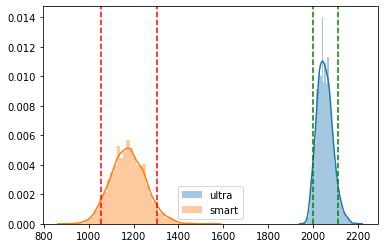

In [240]:
ax = sns.distplot(res_ultra_revenue,label = 'ultra') # график экспериментов по тарифу ultra
sns.distplot(res_smart_revenue,ax=ax,label = 'smart') # график экспериментов по тарифу smart
ax.legend(['ultra','smart']) # названия легенд
ax.axvline(np.percentile(res_ultra_revenue,5),linestyle = '--', color='g') # 5% и 95% границы
ax.axvline(np.percentile(res_ultra_revenue,95),linestyle = '--', color='g')

ax.axvline(np.percentile(res_smart_revenue,5),linestyle = '--', color='r')  # 5% и 95% границы
ax.axvline(np.percentile(res_smart_revenue,95),linestyle = '--', color='r')

1. Средняя выручка по двум тарифам различается
2. Оба графика стремяться  кнормальному распределению
3. Пользователи тарифа ultra находяться в близких окресностях среднего значения
4. Пользователи тарифа smart более разрознены относительно среднего значения. Есть потенциал для разработки новых тарифов и увеличение прибыли.
5. 

## 2. Различается ли выручка в Москве по сравнению с другими регионами.

In [241]:
res_no_msk = bootstrap(gr_all.query('city!="Москва"')['money'],N_TRAIL = 3000,n=1000)

In [242]:
res_moscow = bootstrap(gr_all.query('city=="Москва"')['money'],N_TRAIL = 3000,n=1000)

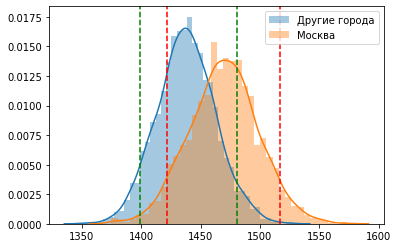

In [243]:
ax = sns.distplot(res,label = 'Другие города')
sns.distplot(res_moscow,ax=ax,label = 'Москва')
ax.legend(['Другие города','Москва'])
ax.axvline(np.percentile(res_no_msk,5),linestyle = '--', color='g')
ax.axvline(np.percentile(res_no_msk,95),linestyle = '--', color='g')

ax.axvline(np.percentile(res_moscow,5),linestyle = '--', color='r')
ax.axvline(np.percentile(res_moscow,95),linestyle = '--', color='r')

1. Средние выручки с разных тарифов в Москве и других регионах практически не отличается
2. Графики стремяться к нормальному распределению

# Шаг 5. Общие выводы.

### 1. В данных есть ошибки необходимо поработать с поставщиком данных.
### 2. Пользователи тарифа ultra более разнообразны в расходе смс, интернет трафика и звонков.
### 3. Пользовтали тарифа smart более экономичны и большенство держиться в среднеи значении расхода.
### 4. Для аудитории тарифа smart расположенной в правом хвосте распределений можно разработать другой тариф для получения большей прибыли или же убедить перейти их на тариф ultra который более выгоден для компании.
### 5. Все графики имеют нормальное распределение.

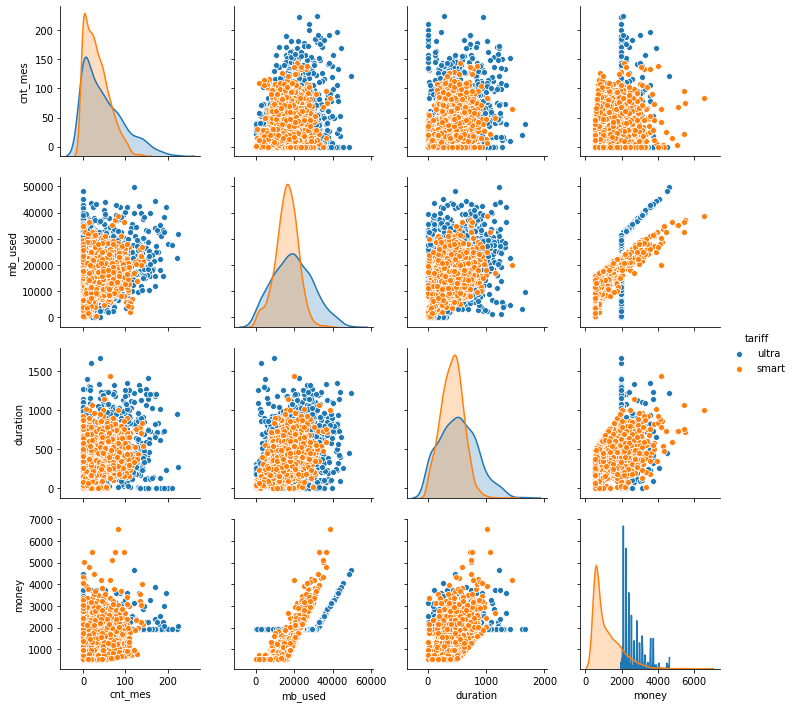

In [235]:
sns.pairplot(data = gr_all,hue = 'tariff') 

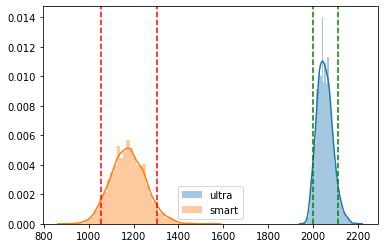

In [244]:
ax = sns.distplot(res_ultra_revenue,label = 'ultra') # график экспериментов по тарифу ultra
sns.distplot(res_smart_revenue,ax=ax,label = 'smart') # график экспериментов по тарифу smart
ax.legend(['ultra','smart']) # названия легенд
ax.axvline(np.percentile(res_ultra_revenue,5),linestyle = '--', color='g') # 5% и 95% границы
ax.axvline(np.percentile(res_ultra_revenue,95),linestyle = '--', color='g')
ax.axvline(np.percentile(res_smart_revenue,5),linestyle = '--', color='r')  # 5% и 95% границы
ax.axvline(np.percentile(res_smart_revenue,95),linestyle = '--', color='r')

### Выручки пользователей тарифов разричаются 

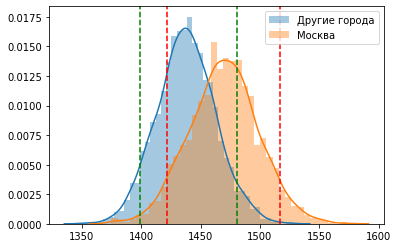

In [245]:
ax = sns.distplot(res,label = 'Другие города')
sns.distplot(res_moscow,ax=ax,label = 'Москва')
ax.legend(['Другие города','Москва'])
ax.axvline(np.percentile(res_no_msk,5),linestyle = '--', color='g')
ax.axvline(np.percentile(res_no_msk,95),linestyle = '--', color='g')
ax.axvline(np.percentile(res_moscow,5),linestyle = '--', color='r')
ax.axvline(np.percentile(res_moscow,95),linestyle = '--', color='r')

### Средняя выручка не зависит от того находятся ли клиенты в Москве или других регионах.